In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
torch.manual_seed(123)  


import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(123) # pytorch seed, to keep loss stability in the working environment 
plt.style.use('ggplot')

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200  # highres display
plt.rcParams["figure.figsize"] = (16, 6)
plt.rcParams.update({'font.size': 22})


def calculate_temperature(T_0, T_env, r, time):
    temperature_at_t = T_env + (T_0 - T_env) * torch.exp(-r * time)
    return temperature_at_t

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) 
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 1  # Time as input
hidden_size = 32  # Number of neurons in the hidden layer #32
output_size = 1  # Predicted temperature as output

model = SimpleNN(input_size, hidden_size, output_size)

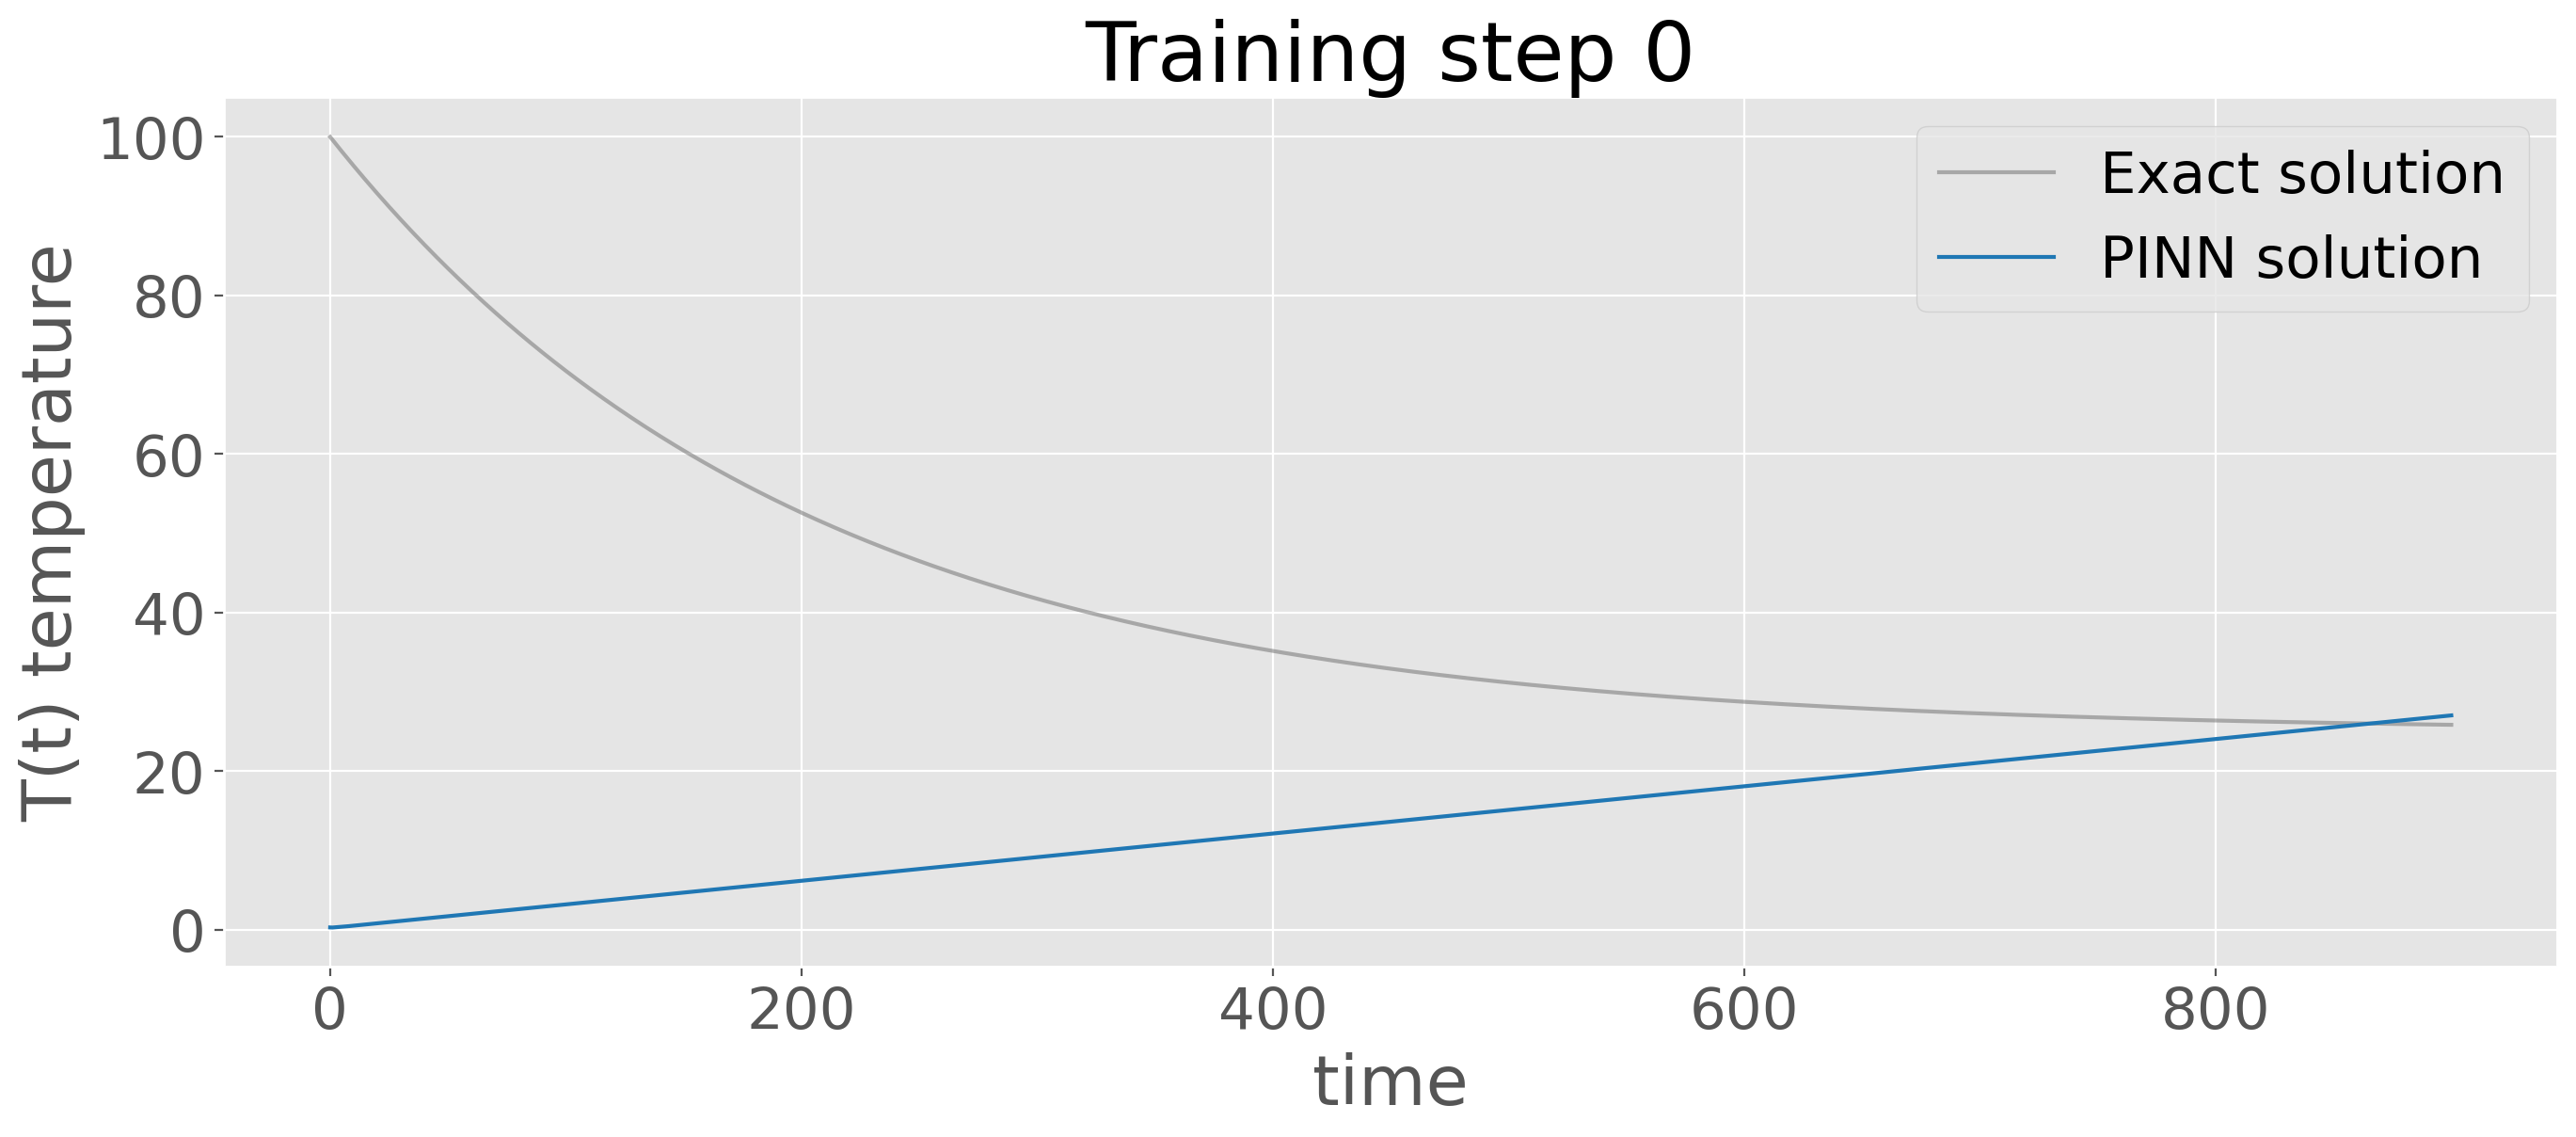

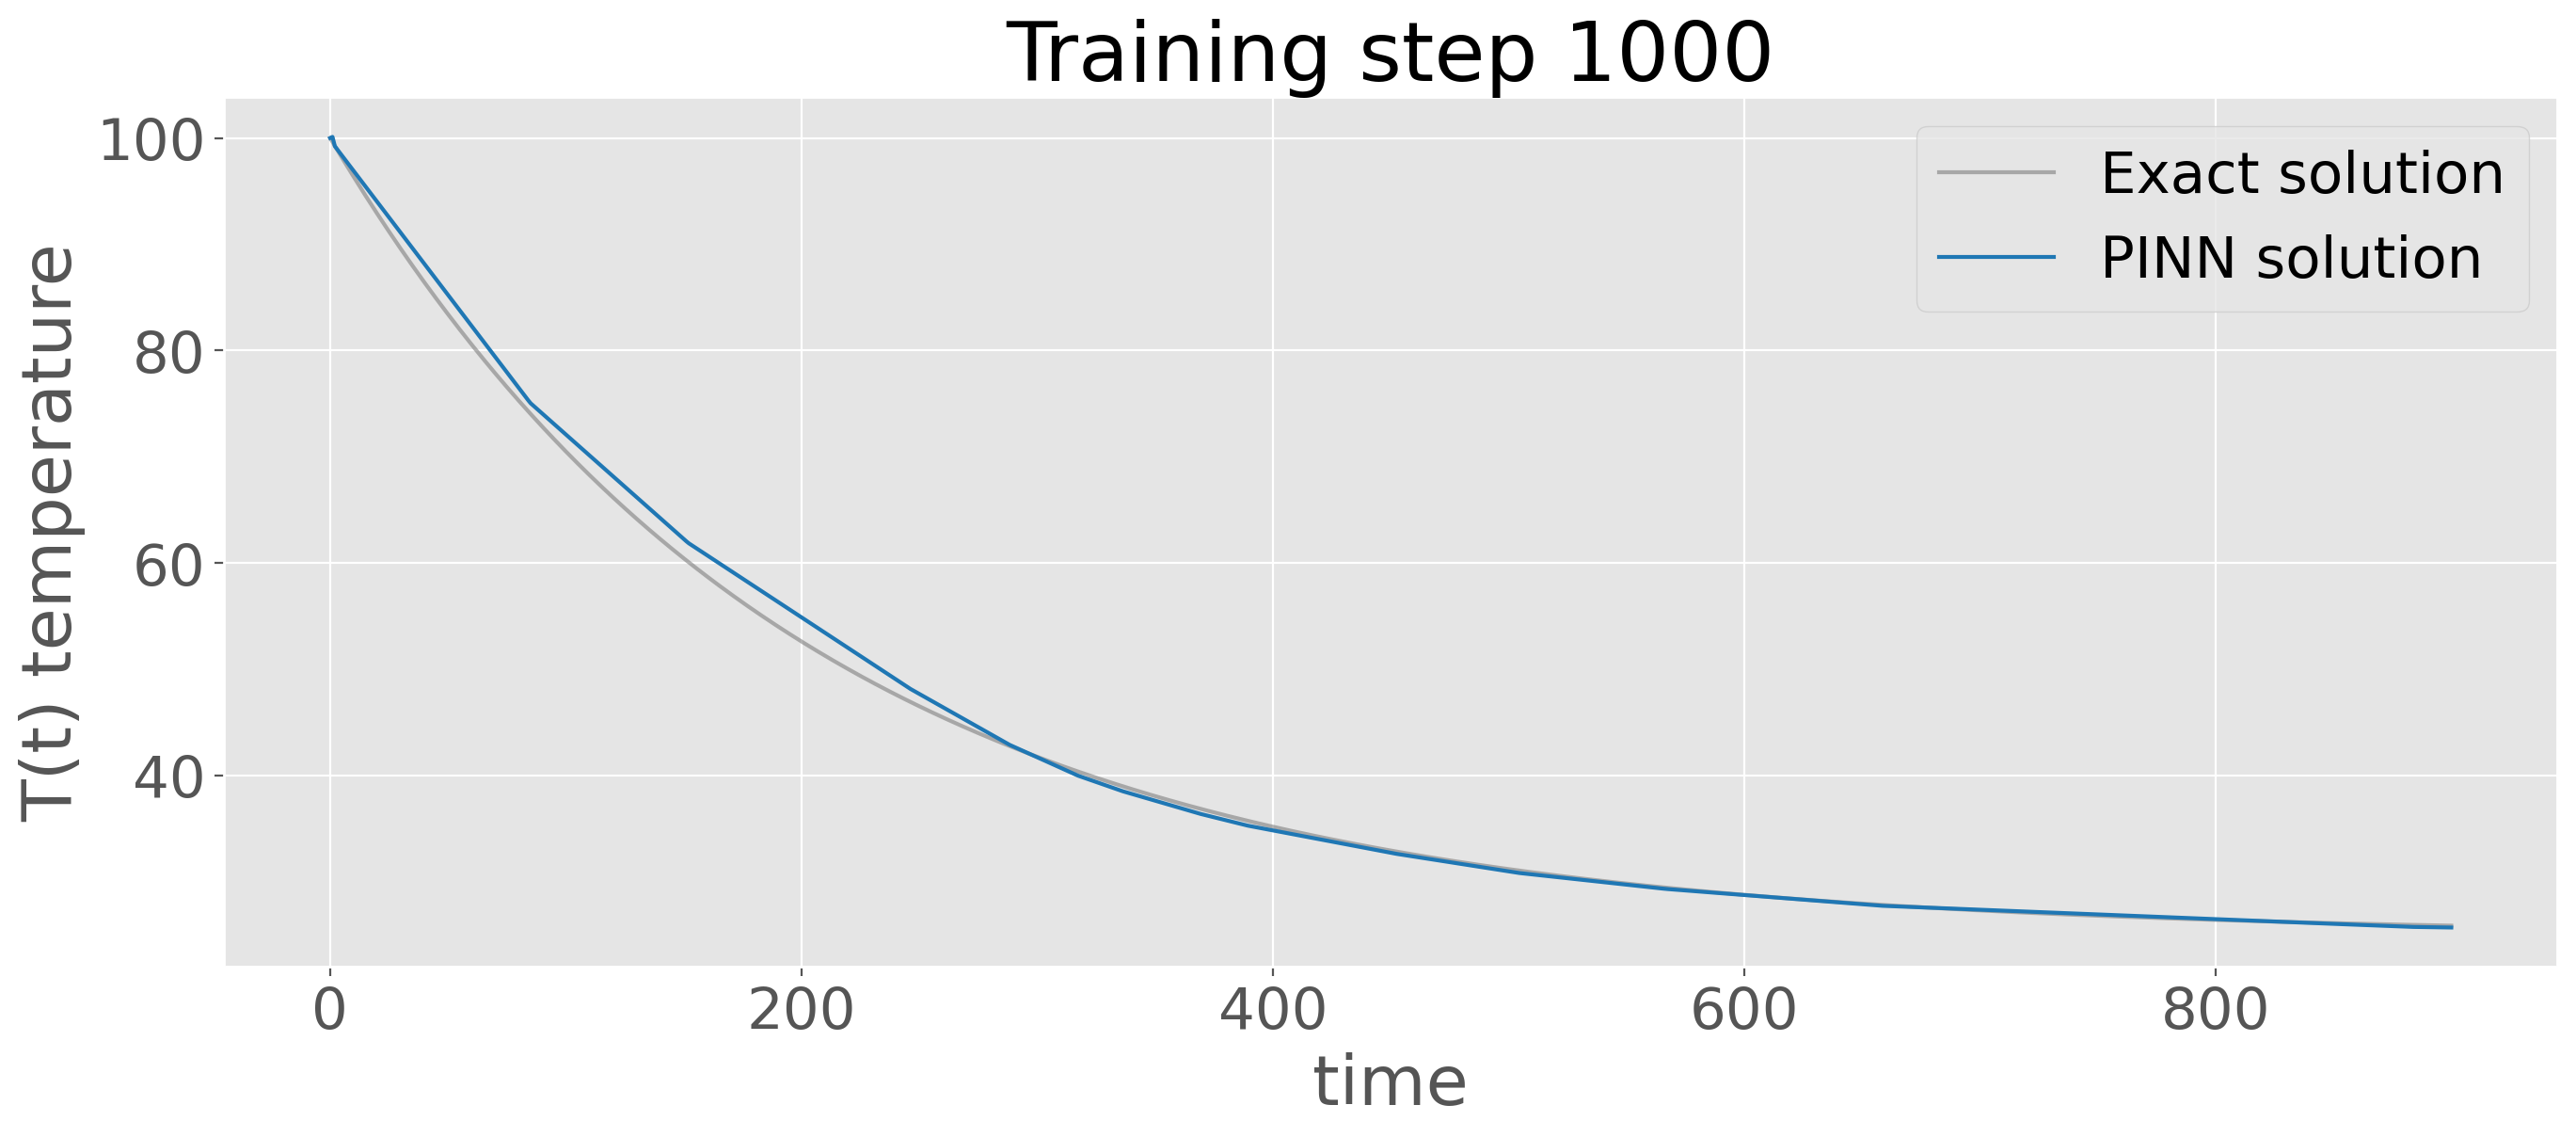

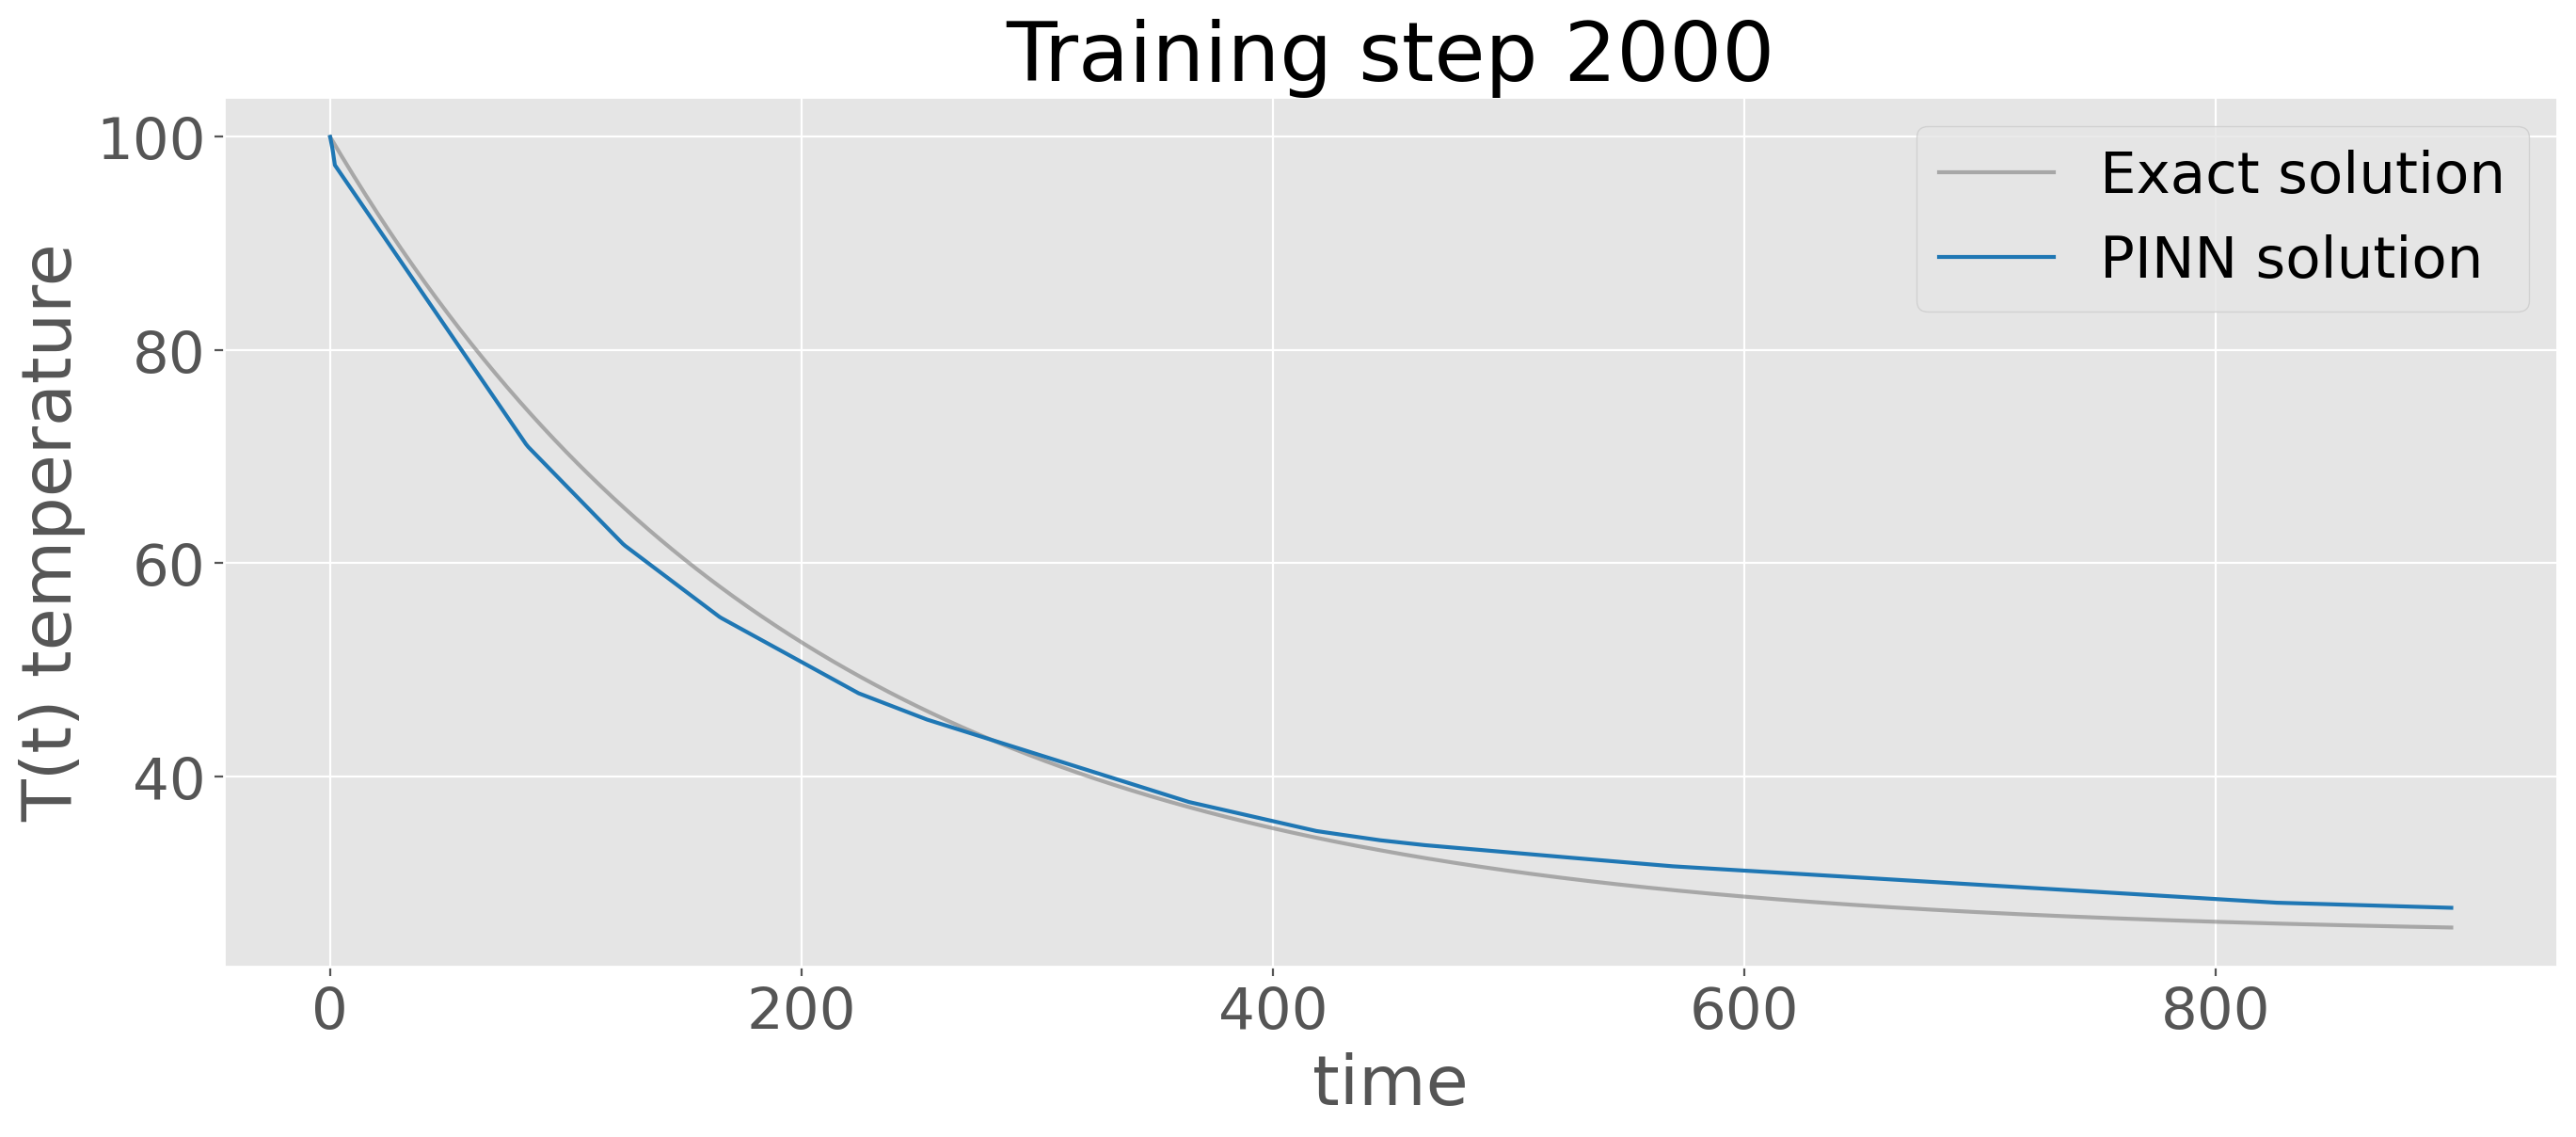

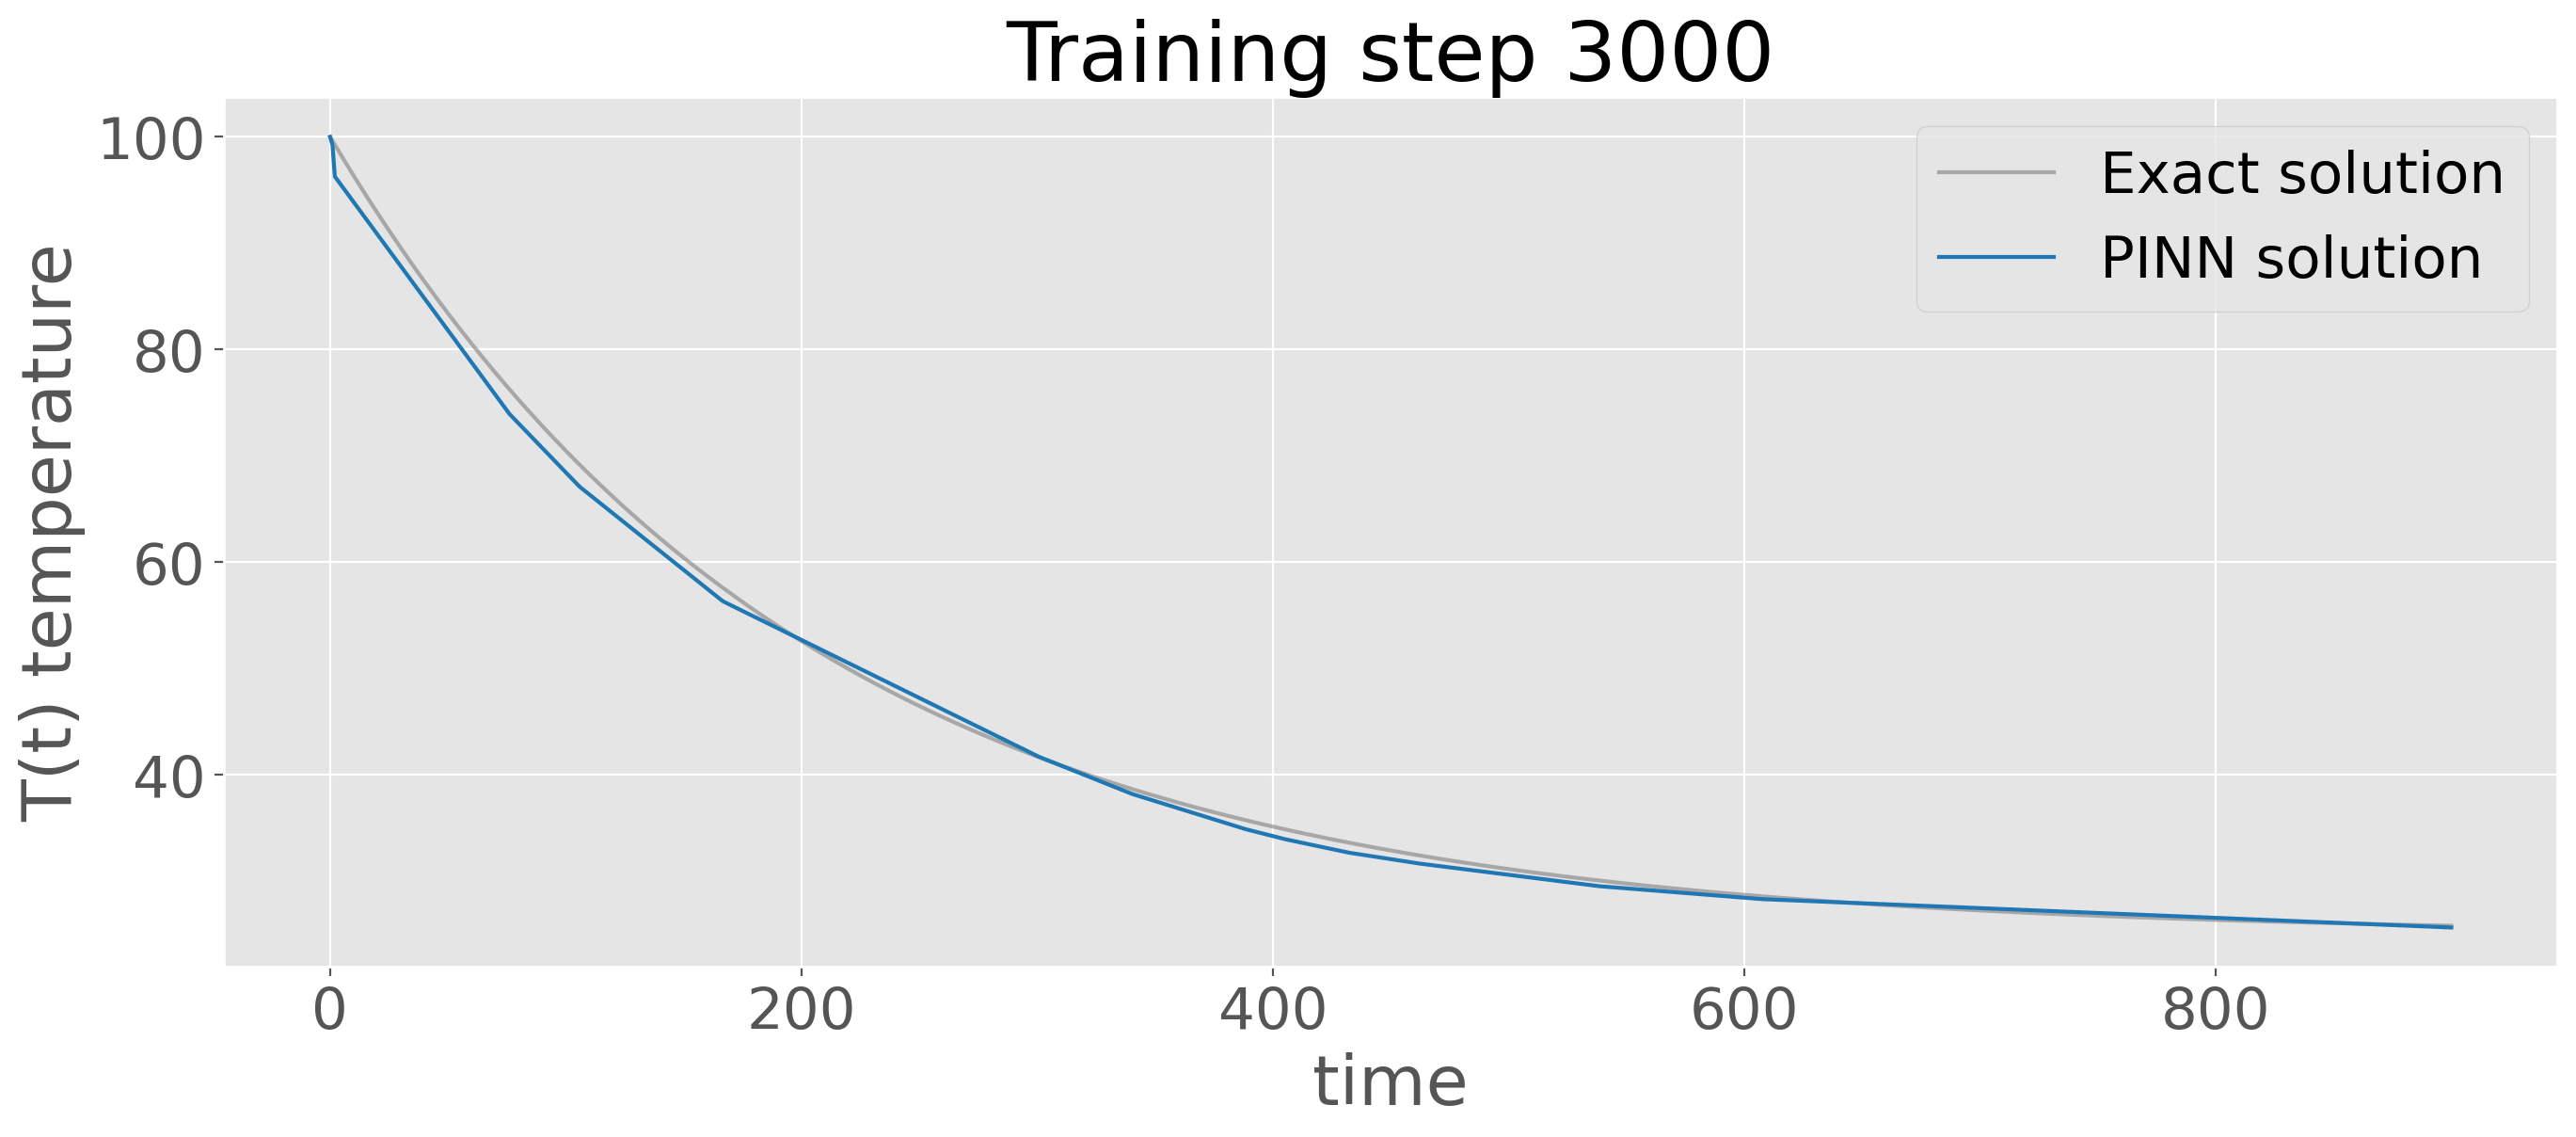

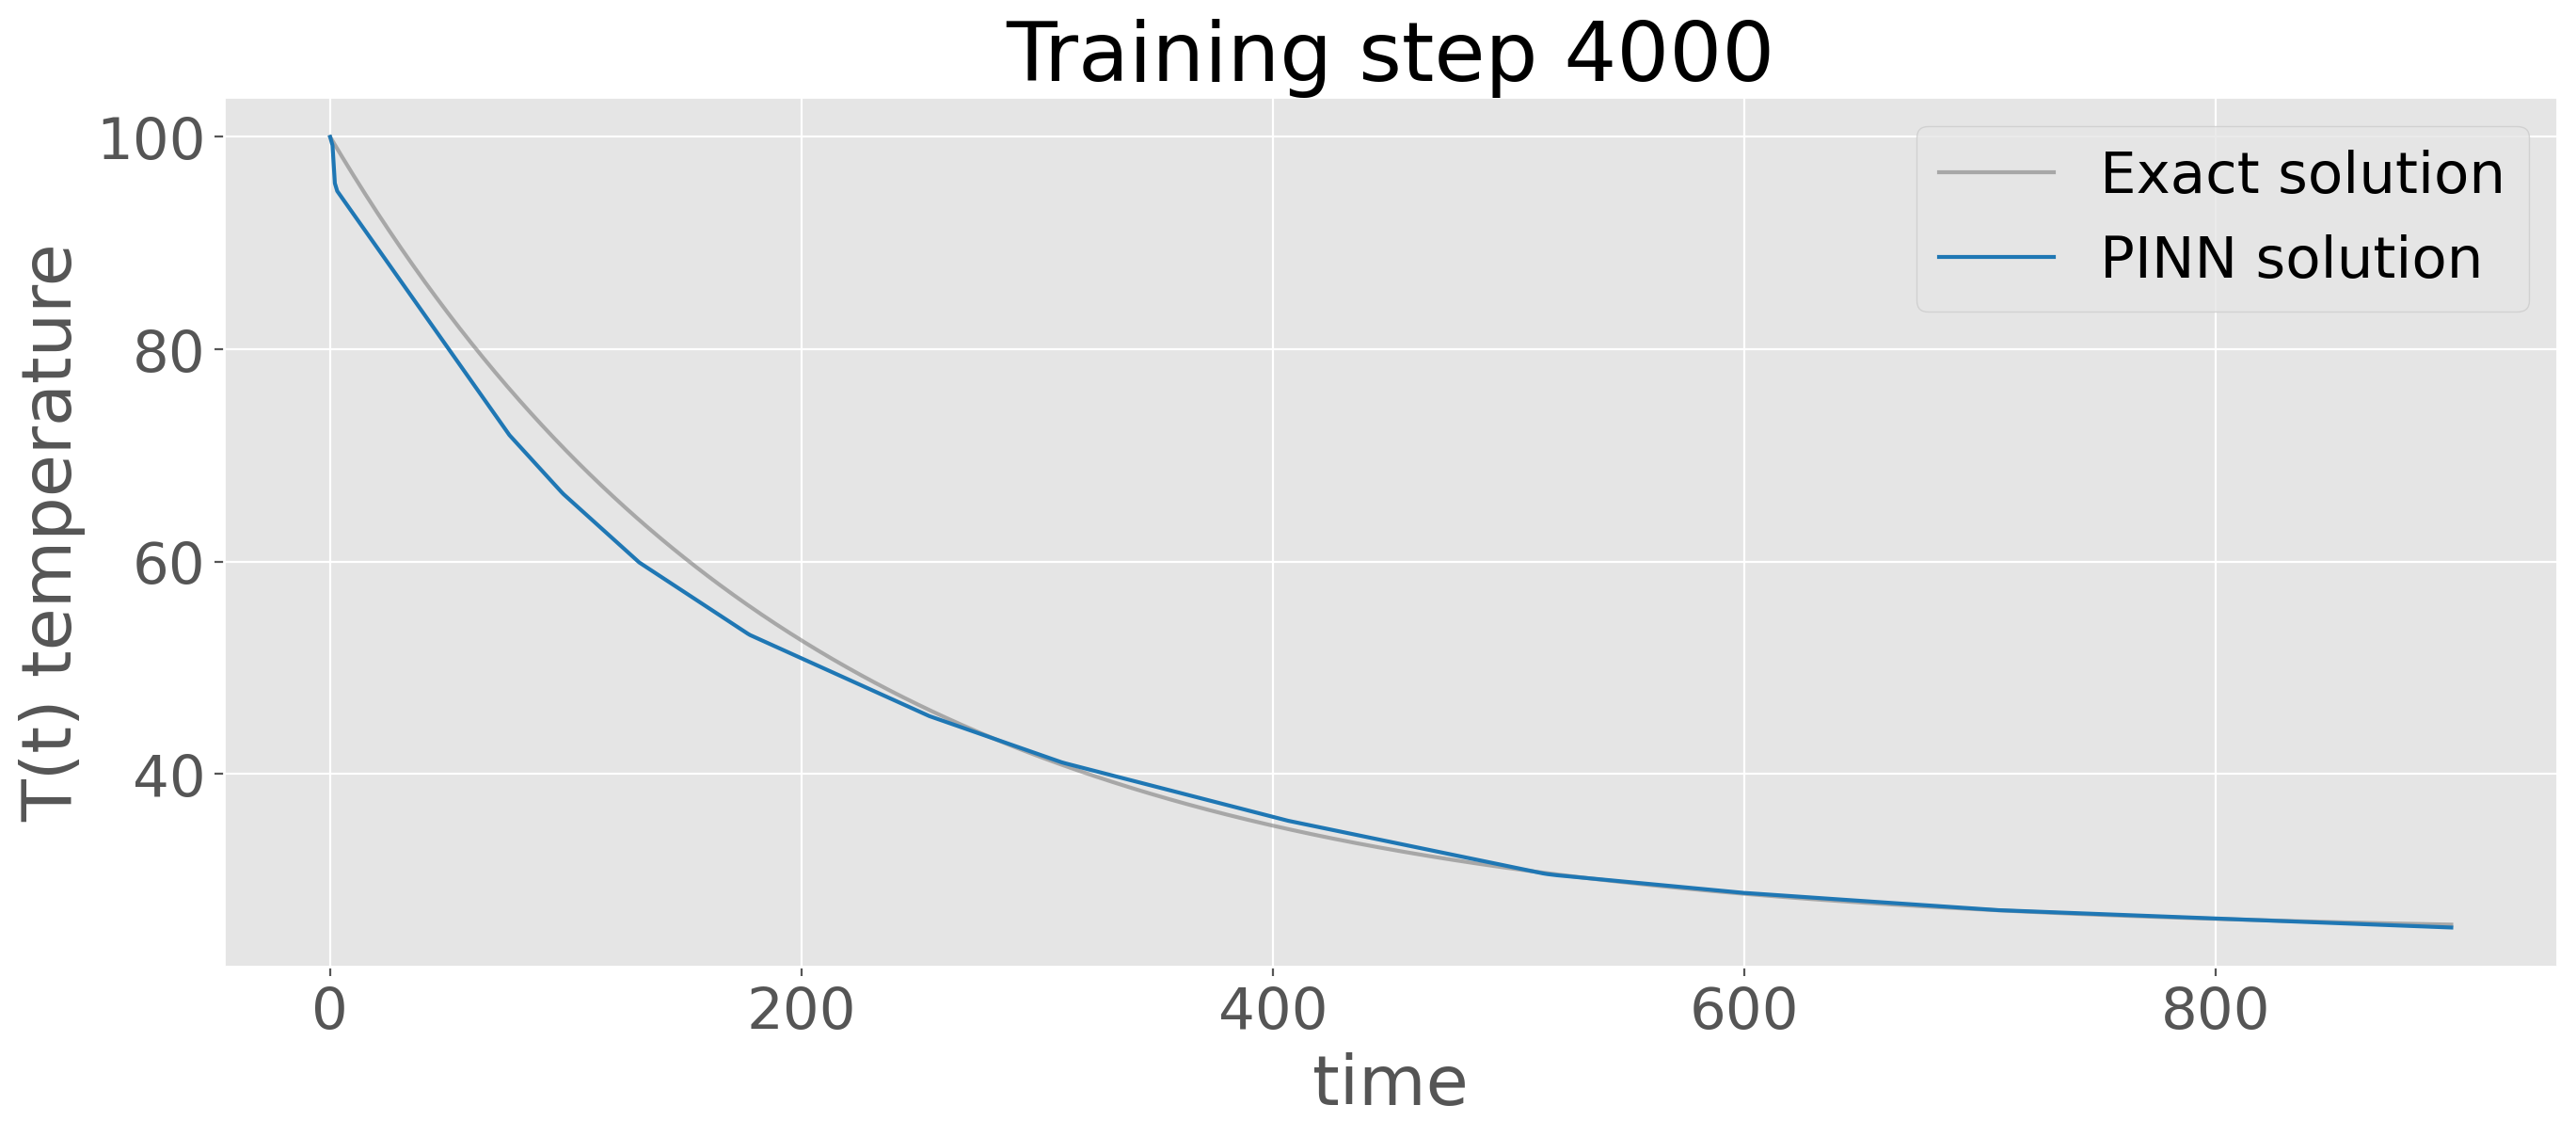

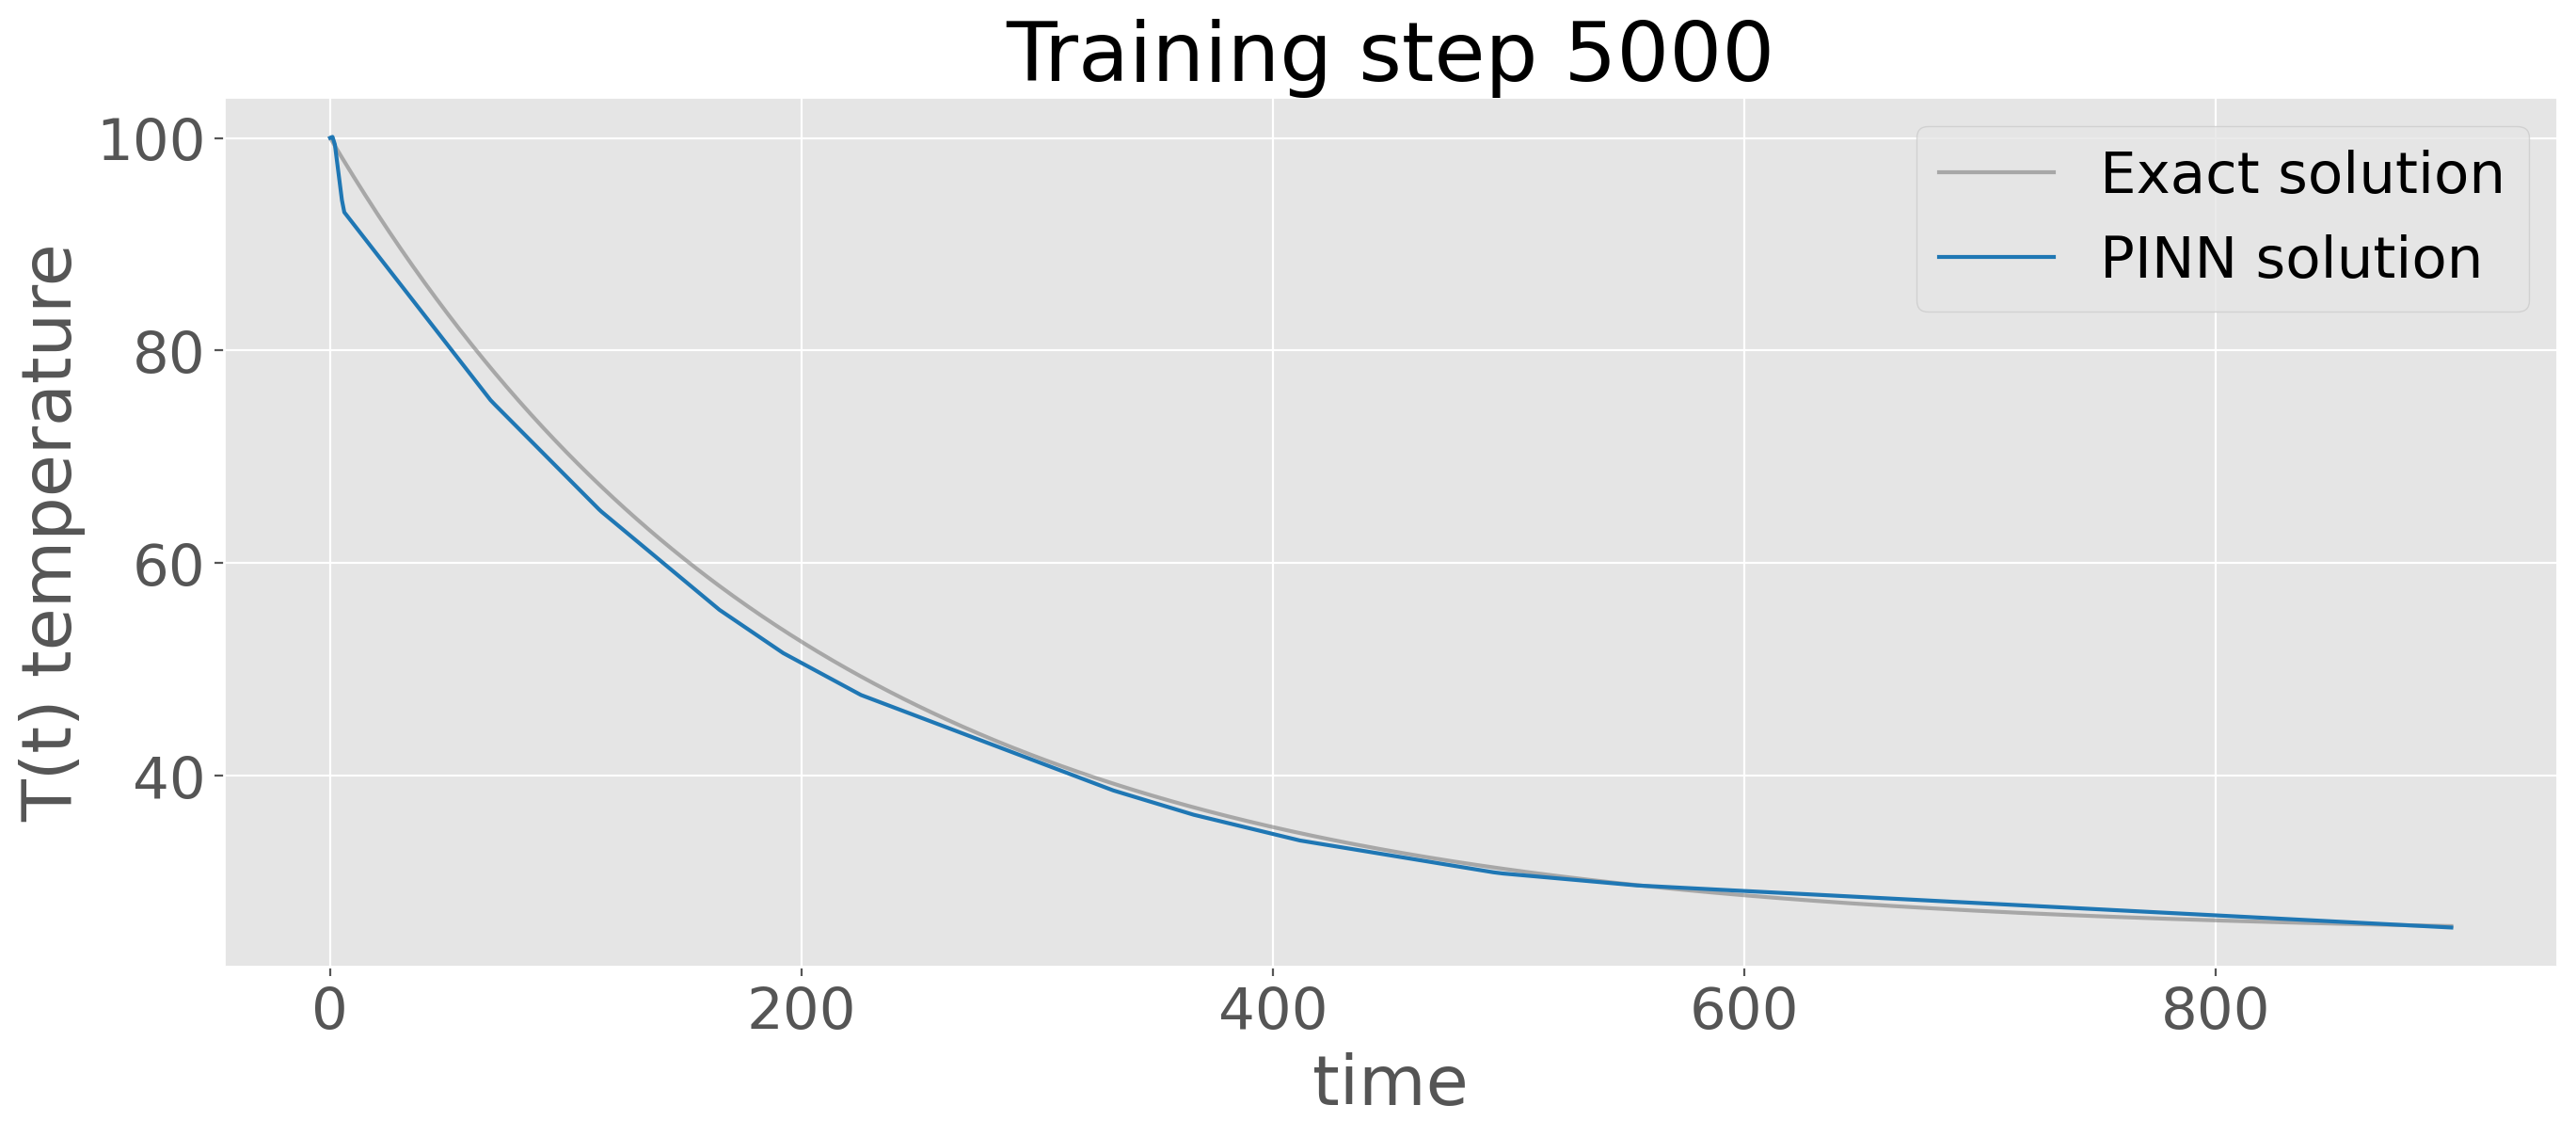

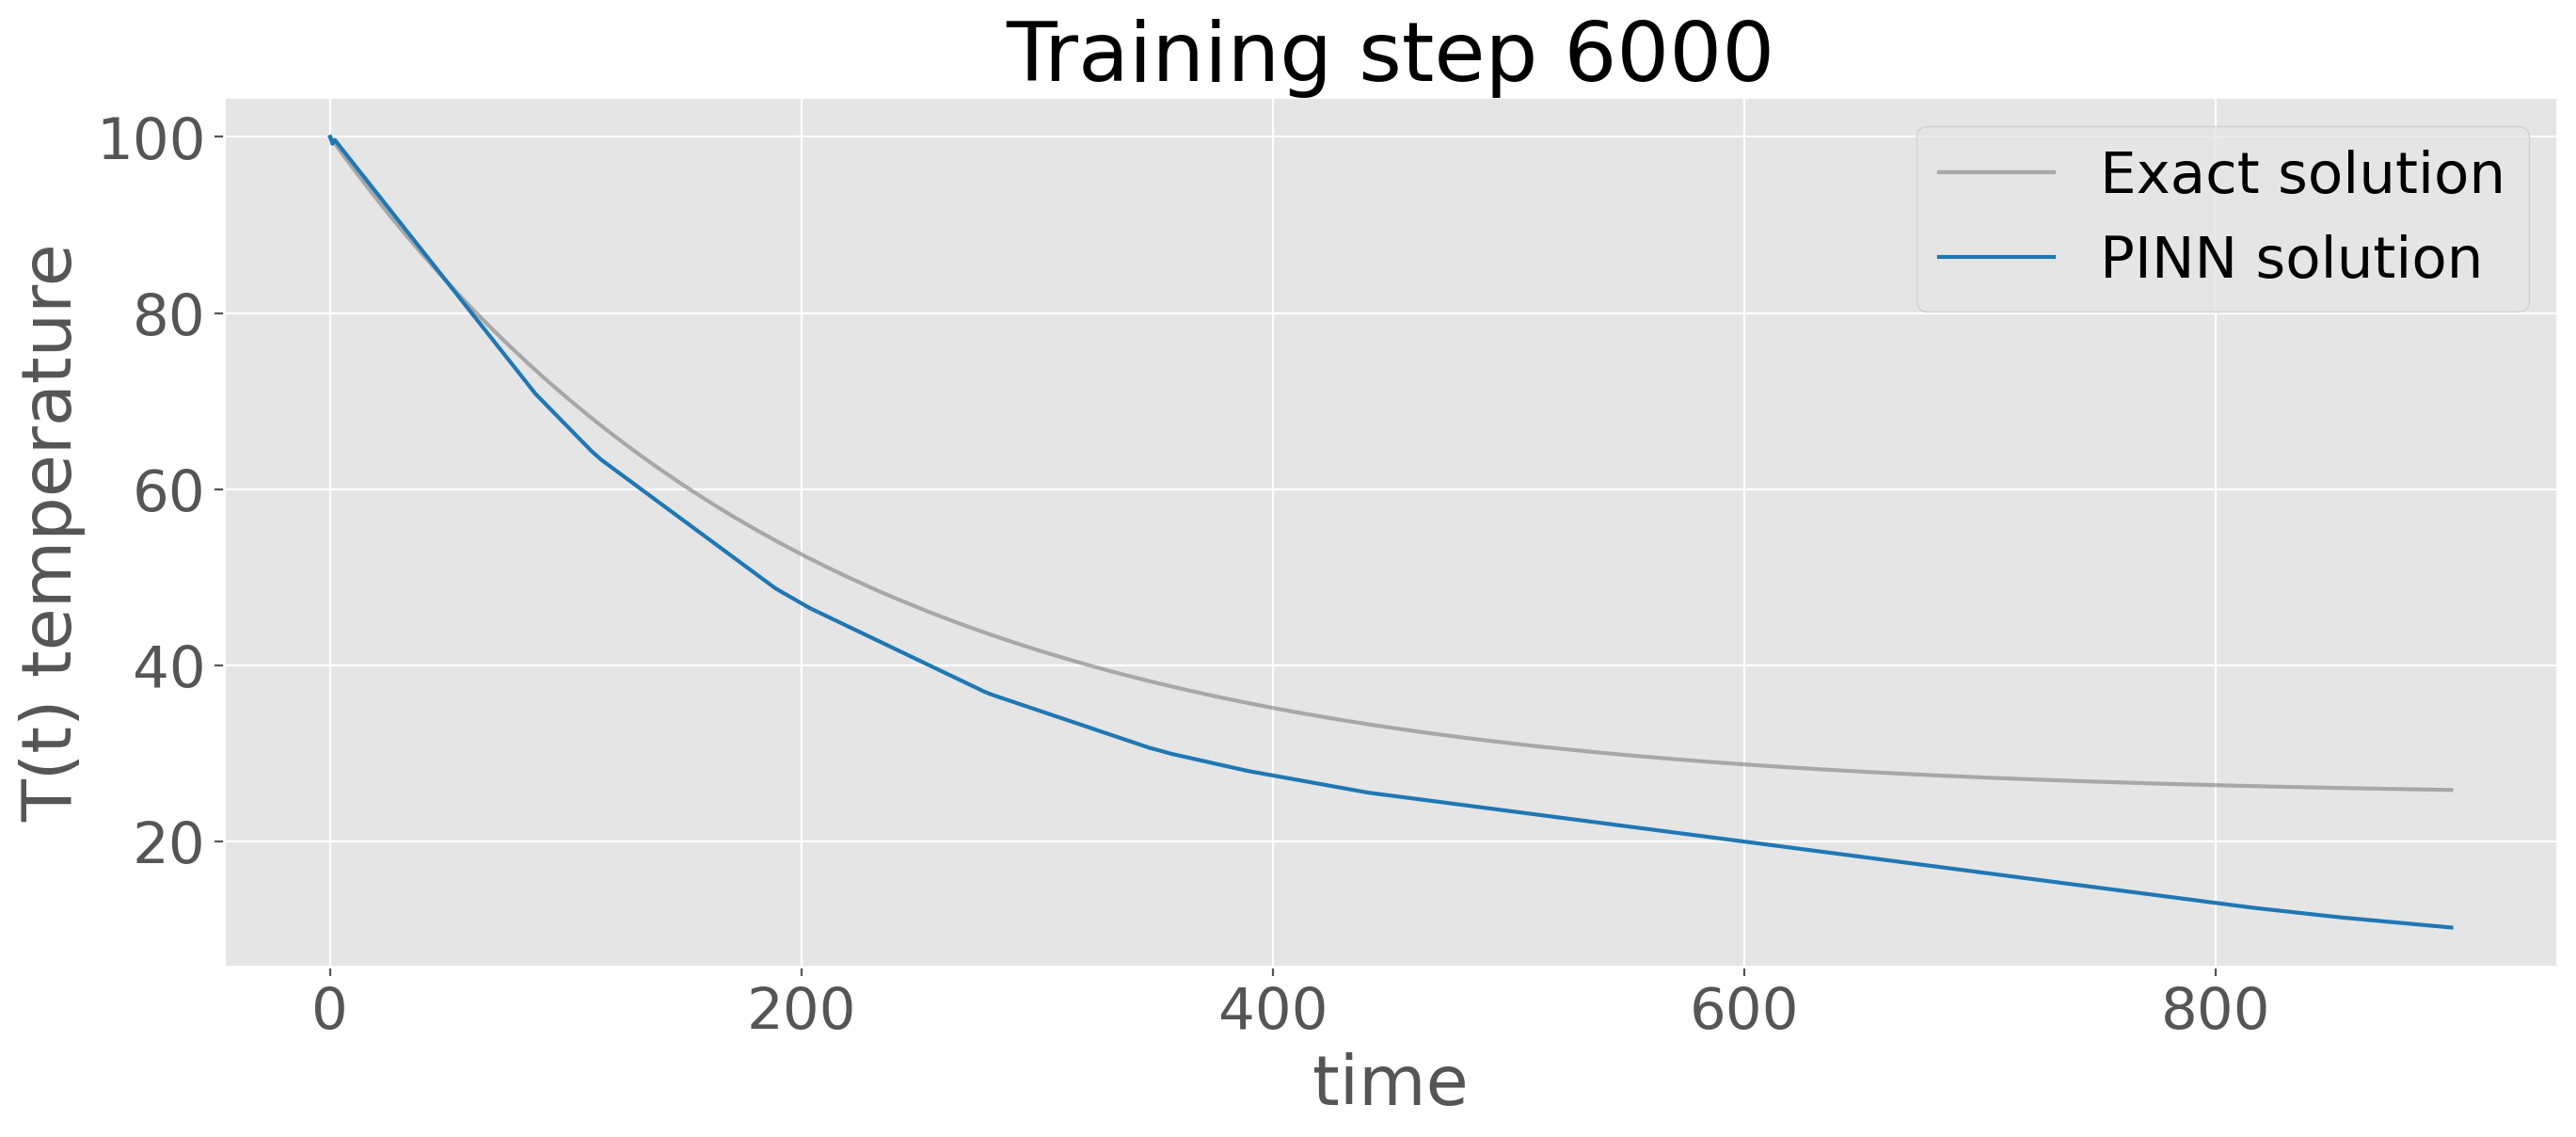

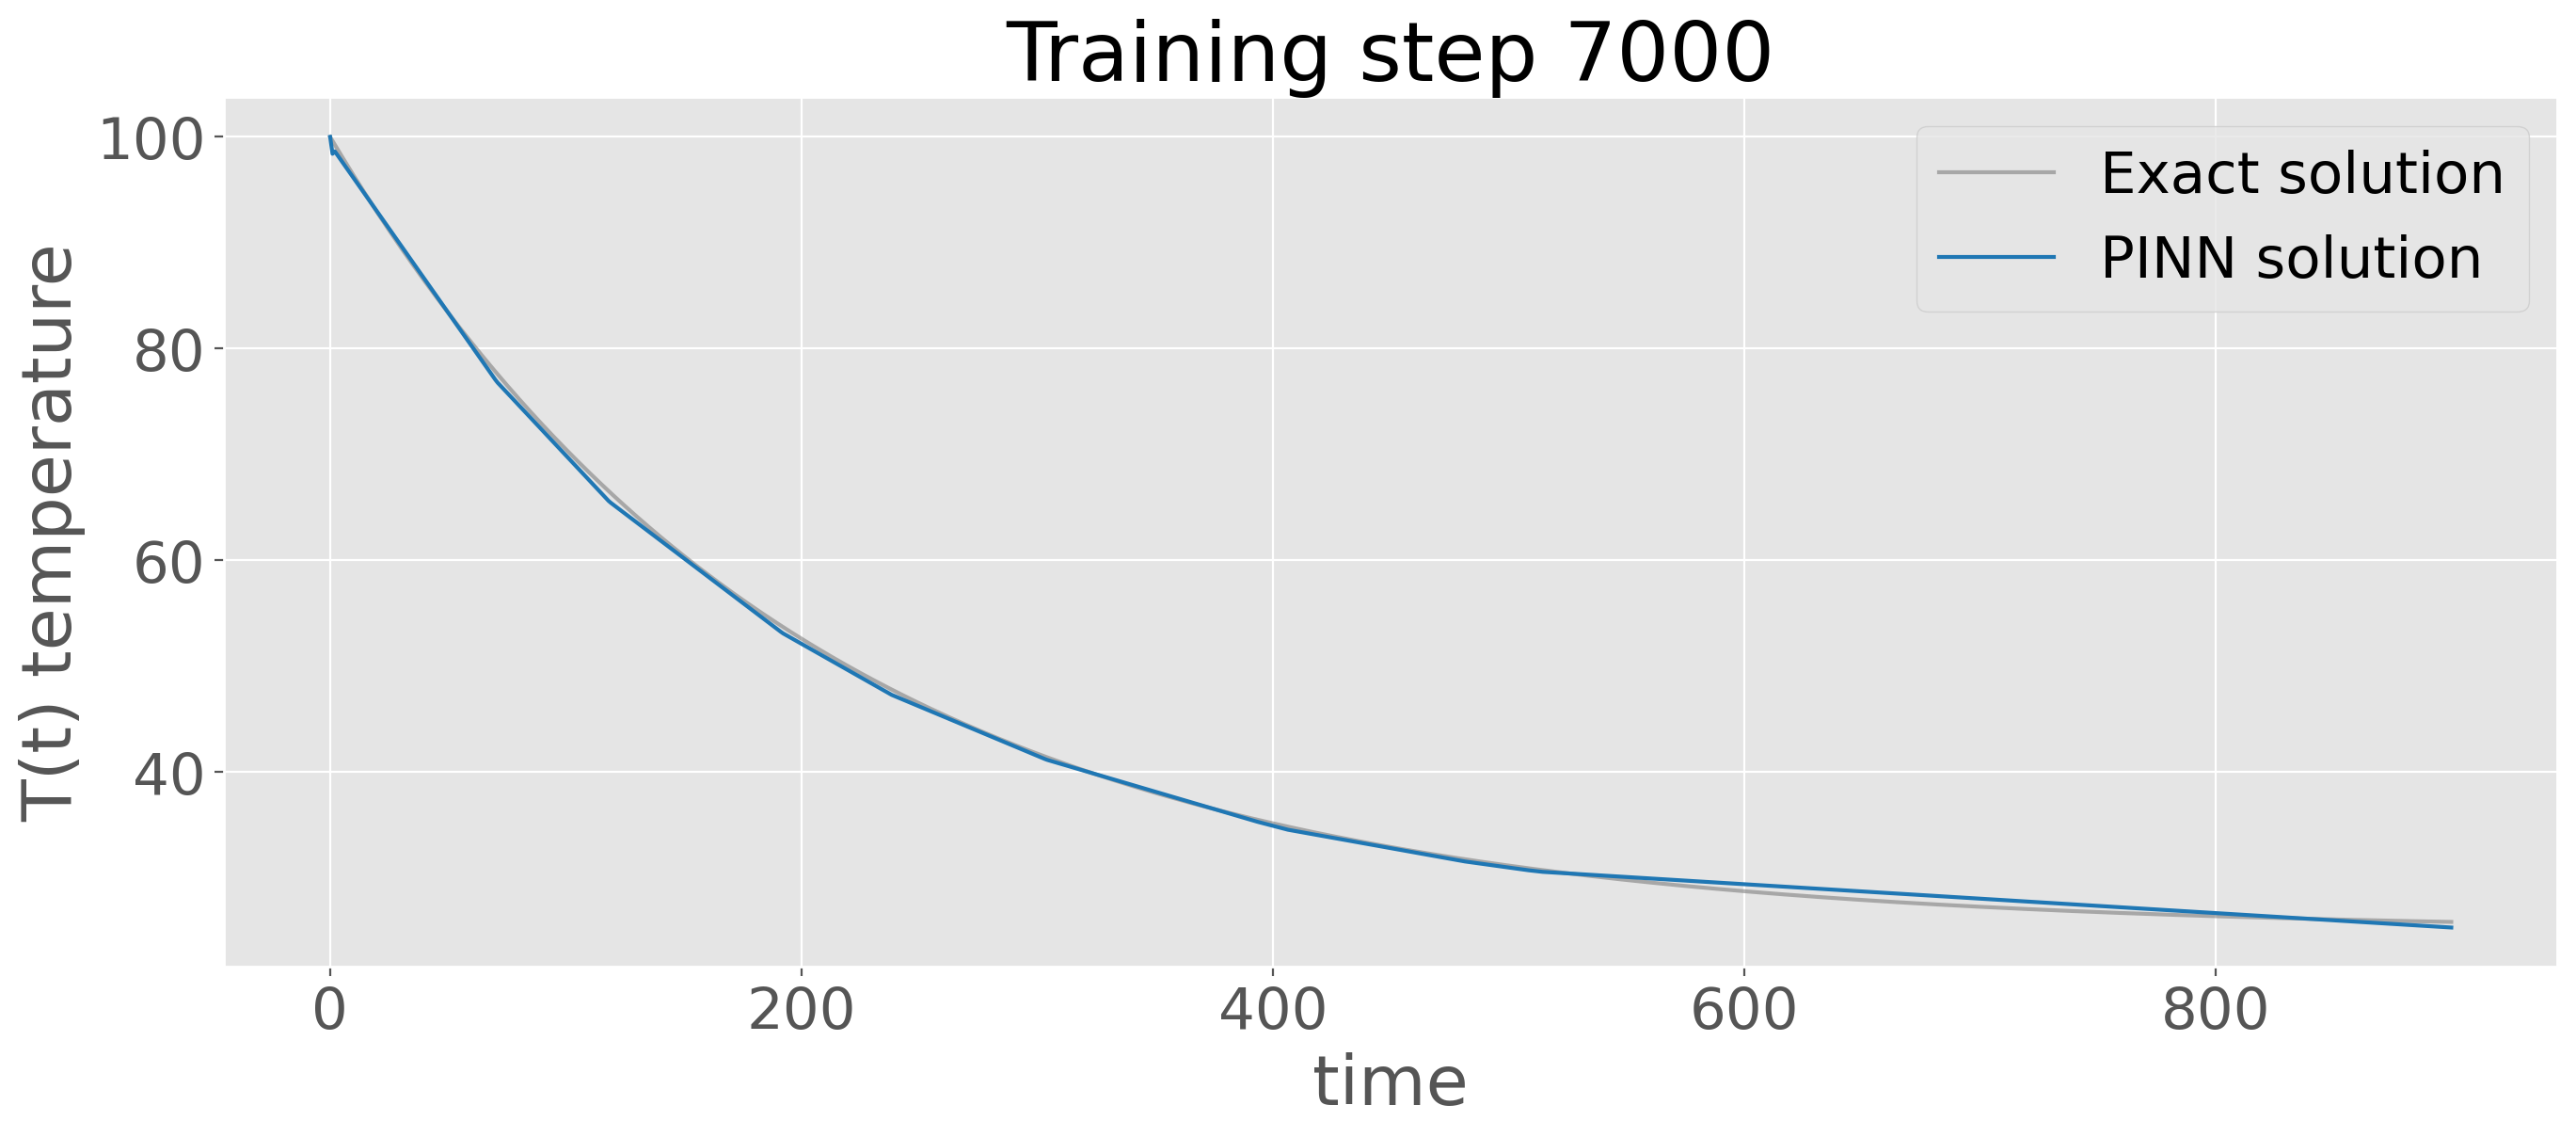

In [2]:
torch.manual_seed(123)
criterion = nn.MSELoss()

# define boundary points, for the boundary loss
time_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
time_physics = torch.linspace(0,900,800).view(-1,1).requires_grad_(True) # works good for 1200

# train the PINN
T_env = 25  # Environment temperature
T_0 = 100   # Initial temperature
r = 0.005   #cooling rate

time_test = torch.linspace(0, 900, 900).view(-1,1)
u_exact = calculate_temperature(100,25,0.005,time_test) 
optimizer = optim.Adam(model.parameters(), lr=1e-3) #3

losses_Direct_original_best = []
for i in range(8000):
    optimizer.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-3, 1e-3 # (2,3 for 3k,1k) original # works good for 2,4 # better at 3,4 at 12k
    
    # compute boundary loss
    u = model(time_boundary )
    loss1 = (torch.squeeze(u) - 100)**2
    dudt = torch.autograd.grad(u, time_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2 
    
    # compute physics loss   
    u = model(time_physics)
    dudt = torch.autograd.grad(u, time_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean(( dudt  - r * (T_env - u))**2) 
    
    # backpropagate joint loss, take optimiser step
  
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward() 
    optimizer.step() 
    losses_Direct_original_best.append(loss.item())
    
   # plot the result as training progresses
    if i % 1000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = model(time_test).detach()
        #plt.figure(figsize=(6,2.5))
        #plt.scatter(time_physics.detach()[:,0], 
                    #torch.zeros_like(time_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        #plt.scatter(time_boundary.detach()[:,0], 
                    #torch.zeros_like(time_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(time_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(time_test[:,0], u[:,0], label="PINN solution", color="tab:blue")
        plt.xlabel('time')
        plt.ylabel('T(t) temperature')  
        plt.title(f"Training step {i}")
        plt.savefig('DirectPINN_plot_best.png', dpi=300)  # 'example_plot.png' is the file name; dpi sets the resolution
        plt.legend()
        plt.show()
      
    
    
    
    # Store losses in a file
with open('losses_Direct_original_best.txt', 'w') as f:
    for epoch, loss in enumerate(losses_Direct_original_best):
        f.write(f"Epoch {epoch+1}: {loss}\n")

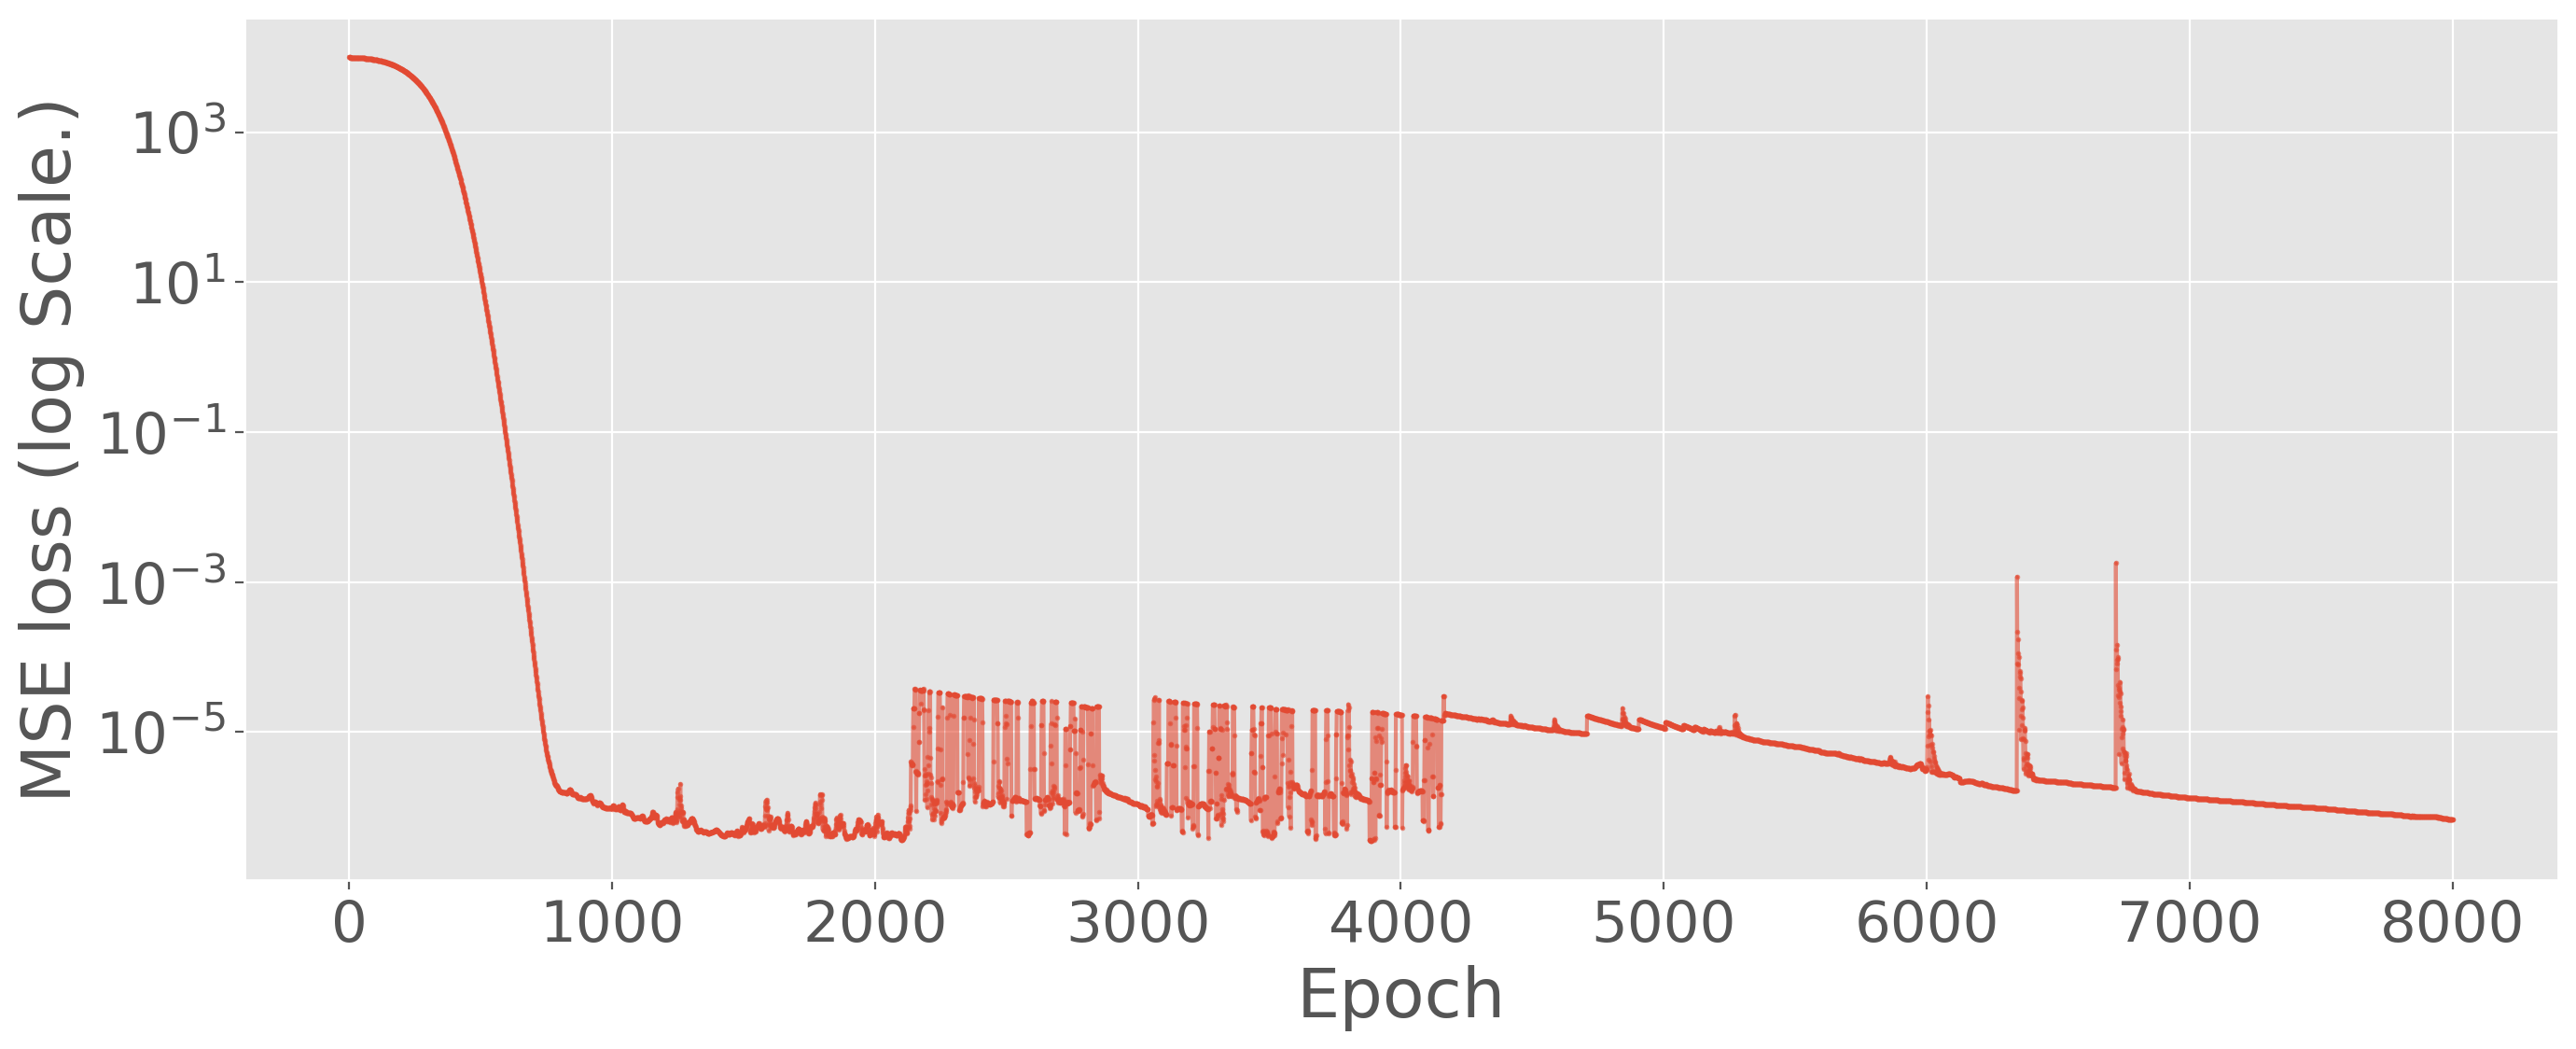

In [3]:
# Visualize MSE vs. Epoch
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(losses_Direct_original_best) + 1),losses_Direct_original_best, marker='o', markersize=1, linestyle='-', alpha=0.6)  # Set markersize to adjust marker size
plt.yscale('log')  # Set y-axis to log scale
#plt.title('MSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE loss (log Scale.)')
plt.grid(True)
plt.savefig('DirectPINN_plot_losscurve_best.png', dpi=300)
plt.show()

# marker size defines the thickness of line


#Optimization and tunning 
#tanh and relu both applied, relu suits the best
#if collocation points taken more then it requres larger lambda value   [(1e-n) ,n smaller number] 
for example , 500 collocation points and lambda1,2 needed (1e-n) ,n=-7 to get good prediction at 12k epoch
and while 800 points, lambda1,2 needed (1e-n) ,n=-4 to get good prediction at 9k epoch

#best output at800, -4-4, 9k

